In [1]:
import os
import time
import math
import random
import pickle
import shutil
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from drift_detectors import *
from forecasters import *
from autoencoder import *
from utils import *
from data import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
# Set a global seed for reproducibility
seed = 42

# Seed Python, NumPy, and PyTorch RNGs
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create and seed a PyTorch Generator (for Dataloaders)
g= torch.Generator()
g.manual_seed(seed)

# Seed CUDA (if available)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior in cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Directory paths for saving and loading components
AE_DIR = "trained_autoencoders"
FORECASTERS_DIR= "trained_forecasters"
RESULTS_DIR = "results"

# Size of the autoencoder bottleneck
latent_dim = 2

# Dataset configurations: (Name, Class, Sequence Length, Window Size)
ts_configs = [
    ("Births",        Births,        None, 10),
    ("OfficeTemp",    OfficeTemp,    None, 10),
    ("SolarPower",    Solar,         None, 10),
]

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



Training AE on Births (window_size=10)
  Epoch 1/30 — loss: 0.571796
  Epoch 2/30 — loss: 0.231702
  Epoch 3/30 — loss: 0.174073
  Epoch 4/30 — loss: 0.152278
  Epoch 5/30 — loss: 0.139907
  Epoch 6/30 — loss: 0.125528
  Epoch 7/30 — loss: 0.118537
  Epoch 8/30 — loss: 0.111724
  Epoch 9/30 — loss: 0.106928
  Epoch 10/30 — loss: 0.100778
  Epoch 11/30 — loss: 0.096188
  Epoch 12/30 — loss: 0.090173
  Epoch 13/30 — loss: 0.087915
  Epoch 14/30 — loss: 0.085979
  Epoch 15/30 — loss: 0.085935
  Epoch 16/30 — loss: 0.081218
  Epoch 17/30 — loss: 0.077968
  Epoch 18/30 — loss: 0.078351
  Epoch 19/30 — loss: 0.077987
  Epoch 20/30 — loss: 0.076120
  Epoch 21/30 — loss: 0.074405
  Epoch 22/30 — loss: 0.071303
  Epoch 23/30 — loss: 0.069087
  Epoch 24/30 — loss: 0.067591
  Epoch 25/30 — loss: 0.067371
  Epoch 26/30 — loss: 0.067508
  Epoch 27/30 — loss: 0.062982
  Epoch 28/30 — loss: 0.064403
  Epoch 29/30 — loss: 0.062352
  Epoch 30/30 — loss: 0.063719
Saved AE: trained_autoencoders\ae_Birth

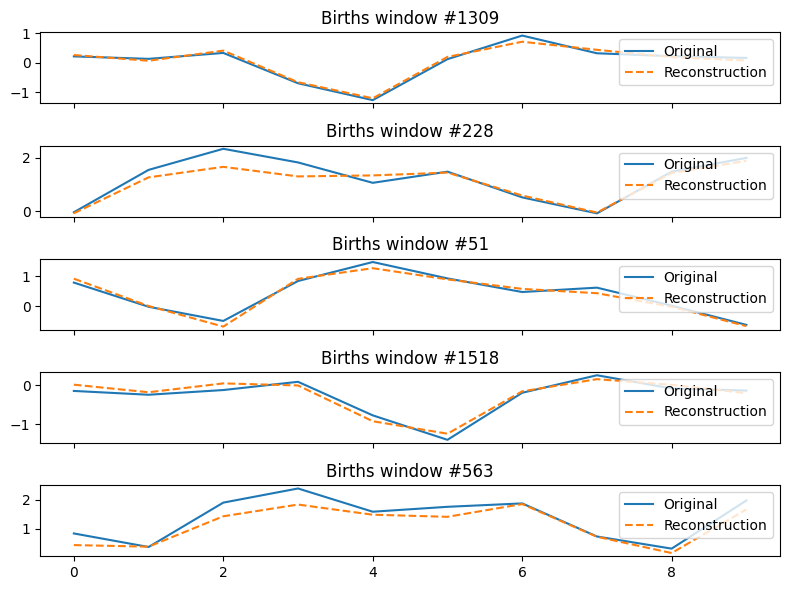


Training AE on OfficeTemp (window_size=10)
  Epoch 1/30 — loss: 0.404414
  Epoch 2/30 — loss: 0.145076
  Epoch 3/30 — loss: 0.115584
  Epoch 4/30 — loss: 0.101120
  Epoch 5/30 — loss: 0.089330
  Epoch 6/30 — loss: 0.074795
  Epoch 7/30 — loss: 0.073234
  Epoch 8/30 — loss: 0.068707
  Epoch 9/30 — loss: 0.068857
  Epoch 10/30 — loss: 0.063769
  Epoch 11/30 — loss: 0.057076
  Epoch 12/30 — loss: 0.057131
  Epoch 13/30 — loss: 0.053374
  Epoch 14/30 — loss: 0.055805
  Epoch 15/30 — loss: 0.053683
  Epoch 16/30 — loss: 0.052657
  Epoch 17/30 — loss: 0.051788
  Epoch 18/30 — loss: 0.051291
  Epoch 19/30 — loss: 0.048990
  Epoch 20/30 — loss: 0.047251
  Epoch 21/30 — loss: 0.050011
  Epoch 22/30 — loss: 0.056512
  Epoch 23/30 — loss: 0.050434
  Epoch 24/30 — loss: 0.047473
  Epoch 25/30 — loss: 0.048813
  Epoch 26/30 — loss: 0.047143
  Epoch 27/30 — loss: 0.046692
  Epoch 28/30 — loss: 0.052553
  Epoch 29/30 — loss: 0.048925
  Epoch 30/30 — loss: 0.048094
Saved AE: trained_autoencoders\ae_O

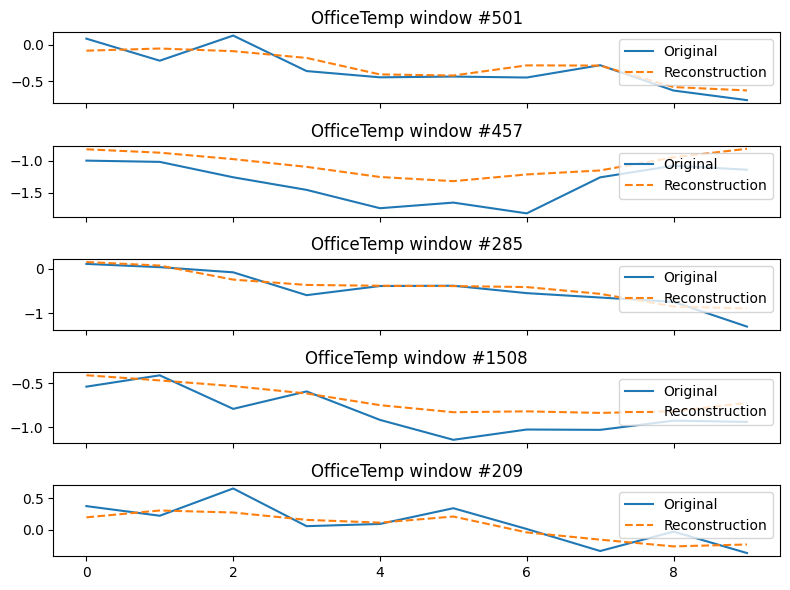


Training AE on SolarPower (window_size=10)
  Epoch 1/30 — loss: 0.582910
  Epoch 2/30 — loss: 0.222882
  Epoch 3/30 — loss: 0.176798
  Epoch 4/30 — loss: 0.148163
  Epoch 5/30 — loss: 0.130813
  Epoch 6/30 — loss: 0.120039
  Epoch 7/30 — loss: 0.110867
  Epoch 8/30 — loss: 0.106595
  Epoch 9/30 — loss: 0.098343
  Epoch 10/30 — loss: 0.093440
  Epoch 11/30 — loss: 0.089355
  Epoch 12/30 — loss: 0.086685
  Epoch 13/30 — loss: 0.085170
  Epoch 14/30 — loss: 0.080145
  Epoch 15/30 — loss: 0.078746
  Epoch 16/30 — loss: 0.075636
  Epoch 17/30 — loss: 0.073015
  Epoch 18/30 — loss: 0.070832
  Epoch 19/30 — loss: 0.068967
  Epoch 20/30 — loss: 0.066816
  Epoch 21/30 — loss: 0.066421
  Epoch 22/30 — loss: 0.063433
  Epoch 23/30 — loss: 0.059895
  Epoch 24/30 — loss: 0.058948
  Epoch 25/30 — loss: 0.057321
  Epoch 26/30 — loss: 0.055887
  Epoch 27/30 — loss: 0.056054
  Epoch 28/30 — loss: 0.055796
  Epoch 29/30 — loss: 0.054995
  Epoch 30/30 — loss: 0.054243
Saved AE: trained_autoencoders\ae_S

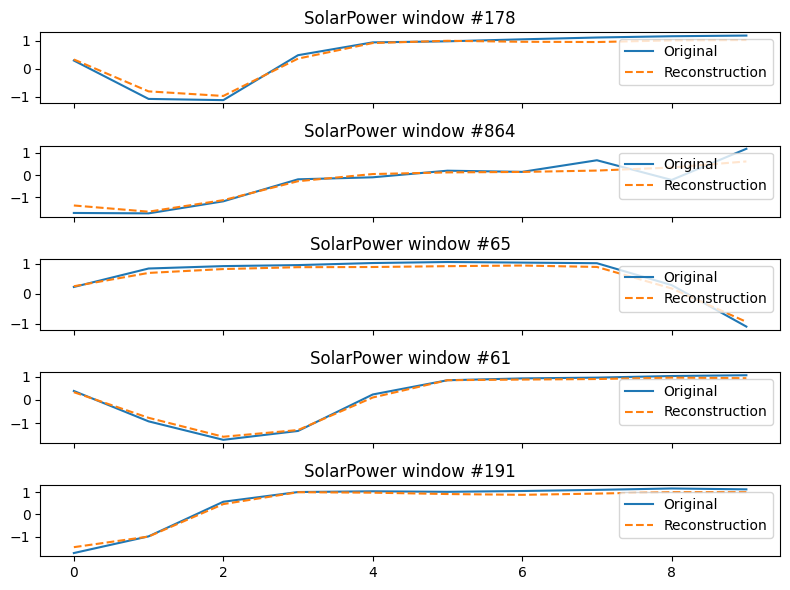

In [4]:
# Autoencoder Training Settings
epochs    = 30
lr        = 1e-3
dropout_p = 0.3

# Ensure a clean autoencoders/ directory
if os.path.exists(AE_DIR):
    shutil.rmtree(AE_DIR)
os.makedirs(AE_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=128, 
        shuffle=True, 
        generator= g
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_val)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [5]:
# Ensure a clean forecasters/ directory
if os.path.exists(FORECASTERS_DIR):
    shutil.rmtree(FORECASTERS_DIR)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    # Stats models   
    "ARIMA": ARIMAForecaster(order=(1,0,0)),
    "ExpSmoothing": ExpSmoothingForecaster(),

    # Linear models / kernels
    "LinearRegression": LinearRegressionForecaster(),
    "SVR": SVRForecaster(kernel='rbf', C=0.5, epsilon=0.05),

    # Trees & ensembles
    "DT": DecisionTreeForecaster(max_depth=3, min_samples_split=3, 
                                 min_samples_leaf=2, random_state=seed),
    "RandomForest": RandomForestForecaster(n_estimators=50, max_depth=3, 
                                           min_samples_split=4,min_samples_leaf=2,
                                           random_state=seed),
    "GradientBoosting": GradientBoostingForecaster(n_estimators=50, max_depth=2, 
                                                   random_state=seed, learning_rate=0.05),

    # MLPs
    "MLP1": MLPForecaster(hidden_layer_sizes=(8,),
                        activation="relu",
                        solver="adam",
                        learning_rate_init=1e-3,
                        max_iter=300,
                        early_stopping=True,
                        n_iter_no_change=10,
                        random_state=seed,
                        ),
    "MLP2": MLPForecaster(hidden_layer_sizes=(16, 8),
                        activation="relu",
                        solver="adam",
                        learning_rate_init=1e-3,
                        max_iter=400,
                        early_stopping=True,
                        n_iter_no_change=10,
                        random_state=seed,
                        ),

    #LSTMs
    "LSTM1": LSTMForecaster(hidden_size=16,
                            num_layers=1,
                            dropout=0.0,
                            lr=1e-3,
                            epochs=30,
                            batch_size=64
                            ),
    "LSTM2": LSTMForecaster(hidden_size=32,
                            num_layers=2,
                            dropout=0.1,
                            lr=1e-3,
                            epochs=30,
                            batch_size=64
            ),


    "BiLSTM1": BiLSTMForecaster(hidden_size=8,
                                num_layers=1,
                                dropout=0.0,
                                lr=3e-4,
                                epochs=30,
                                batch_size=64
            ),
    "BiLSTM2": BiLSTMForecaster(hidden_size=16,
                                num_layers=2,
                                dropout=0.1,
                                lr=1e-3,
                                epochs=30,
                                batch_size=64
            ),


    "CNNLSTM1": CNNLSTMForecaster(conv_channels=(8,),
                                kernel_size=3,
                                lstm_hidden_size=16,
                                lstm_num_layers=1,
                                dropout=0.0,
                                lr=1e-3,
                                epochs=30,
                                batch_size=64
            ),
    "CNNLSTM2": CNNLSTMForecaster(conv_channels=(16, 16),
                                kernel_size=3,
                                lstm_hidden_size=32,
                                lstm_num_layers=2,
                                dropout=0.1,
                                lr=1e-3,
                                epochs=30,
                                batch_size=64
            ),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train, generator=g)

        # save the entire model object as a .pkl
        save_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE")


→ Dataset: Births (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training SVR… DONE
    → Training DT… DONE
    → Training RandomForest… DONE
    → Training GradientBoosting… DONE
    → Training MLP1… DONE
    → Training MLP2… DONE
    → Training LSTM1… 1/30 0.85619 | 15/30 0.21903 | 30/30 0.16925 | DONE
    → Training LSTM2… 1/30 0.75814 | 15/30 0.18485 | 30/30 0.12678 | DONE
    → Training BiLSTM1… 1/30 1.00579 | 15/30 0.53123 | 30/30 0.48352 | DONE
    → Training BiLSTM2… 1/30 0.90573 | 15/30 0.16617 | 30/30 0.11893 | DONE
    → Training CNNLSTM1… 1/30 0.94607 | 15/30 0.15791 | 30/30 0.11562 | DONE
    → Training CNNLSTM2… 1/30 0.79102 | 15/30 0.17739 | 30/30 0.13645 | DONE

→ Dataset: OfficeTemp (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training SVR… DONE
    → Training DT… DONE
    → Training RandomForest… DONE
    → Training G

In [6]:
os.makedirs(AE_DIR, exist_ok=True)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

loaded = {}
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {AE_DIR}{os.sep}")
    
    # Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP1",
        "MLP2",
        "LSTM1",
        "LSTM2",
        "BiLSTM1",
        "BiLSTM2",
        "CNNLSTM1",
        "CNNLSTM2",
    ]:
        pkl_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
    print(f"     Forecasters loaded from {FORECASTERS_DIR}{os.sep}")
    
    # Store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Births (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for OfficeTemp (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for SolarPower (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\


In [17]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # holders for validation signals
    val_means = []
    val_recon_errors = []

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()
            # reconstruct window
            inp = torch.tensor(window, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(next(ae.parameters()).device)
            recon = ae(inp).cpu().squeeze().numpy()  # (window_size,)

        val_means.append(float(np.mean(window)))
        val_recon_errors.append(mean_squared_error(window, recon))


        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")

    val_means = np.asarray(val_means, dtype=float)
    val_recon_errors = np.asarray(val_recon_errors, dtype=float)

    mu_ref_mean   = float(val_means.mean())
    mu_ref_recon  = float(val_recon_errors.mean())

    # empirical ranges (use central 99% interval, then add 10% cushion)
    #ql_m, qh_m = np.quantile(val_means, [0.005, 0.995])
    #R_MEAN  = float((qh_m - ql_m) * 1.10) # 5
    R_MEAN  = (np.max(val_means) - np.min(val_means)) * 1

    #ql_e, qh_e = np.quantile(val_recon_errors, [0.005, 0.995])
    #R_RECON = float(max((qh_e - ql_e) * 1.10, (qh_e - ql_e) * 1.10)) # 2
    R_RECON =(np.max(val_recon_errors) - np.min(val_recon_errors)) * 1

    loaded[ds_name]["detector_refs"] = {
        "mu_ref_mean":  mu_ref_mean,
        "mu_ref_recon": mu_ref_recon,
        "R_MEAN":       R_MEAN,
        "R_RECON":      R_RECON,
        # keep raw stats
        #"val_means_q":  (float(ql_m), float(qh_m)),
        #"val_err_q":    (float(ql_e), float(qh_e)),
    }


=== Validation RoC for Births (window_size=10) ===
RoC sizes
  ARIMA                31 entries
  ExpSmoothing        102 entries
  LinearRegression    153 entries
  RandomForest        144 entries
  SVR                 123 entries
  GradientBoosting    104 entries
  DT                  130 entries
  MLP1                184 entries
  MLP2                193 entries
  LSTM1                98 entries
  LSTM2               133 entries
  BiLSTM1              33 entries
  BiLSTM2             134 entries
  CNNLSTM1            103 entries
  CNNLSTM2            151 entries

=== Validation RoC for OfficeTemp (window_size=10) ===
RoC sizes
  ARIMA               287 entries
  ExpSmoothing        124 entries
  LinearRegression     87 entries
  RandomForest        178 entries
  SVR                  56 entries
  GradientBoosting    147 entries
  DT                  281 entries
  MLP1                145 entries
  MLP2                 94 entries
  LSTM1                28 entries
  LSTM2               

In [18]:
def retrain_autoencoder(X, ds_name, batch_size=128):

    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()

    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X, dtype=torch.float).unsqueeze(1)),
        batch_size=batch_size,
        shuffle=True,
        generator=g
    )

    for epoch in range(1, epochs + 1):
        ae.train()
        losses = []
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon = ae(batch_x)
            loss = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    ckpt_path = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)

    return ae.eval()

In [19]:
def rebuild_rocs(ae, forecasters, X, y, append=False):
    """
    Rebuilds or appends to each model's Region of Competence (RoC) based on validation data.
    """
    if not append:
        for model in forecasters.values():
            model.rocs["raw"].clear()
            model.rocs["latent"].clear()

    ae.eval()
    for idx, window in enumerate(X):
        errors = {
            name: mean_squared_error([y[idx]], [model.predict(window)])
            for name, model in forecasters.items()
        }
        winner = min(errors, key=errors.get)

        # Encode latent vector
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(window)
        forecasters[winner].rocs["latent"].append(latent_vec)

    return forecasters

> Bottleneck size: 2, Adaptation set size: 0.25, Append to old RoC: False, Split train/val: 75.0%

=== Dataset: Births ==
> Detectors and parameters:
  None: None (no drift detection)
  recon error: mu0=0.0657, r=0.422820, sigma=0.026
  mean: mu0=0.7713, r=2.454905, sigma=0.01
[Metric: cosine] Detector: None       | MSE: 0.3607 | Time: 49.88s | Drifts: 0


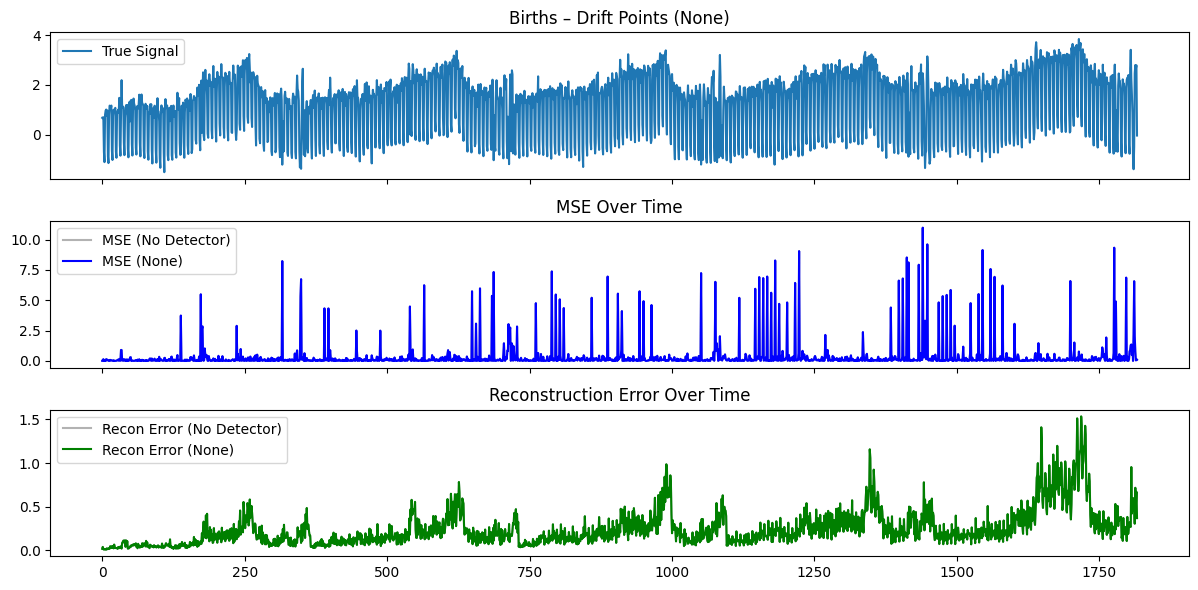

[Metric: cosine] Detector: recon error | MSE: 0.2823 | Time: 46.77s | Drifts: 3


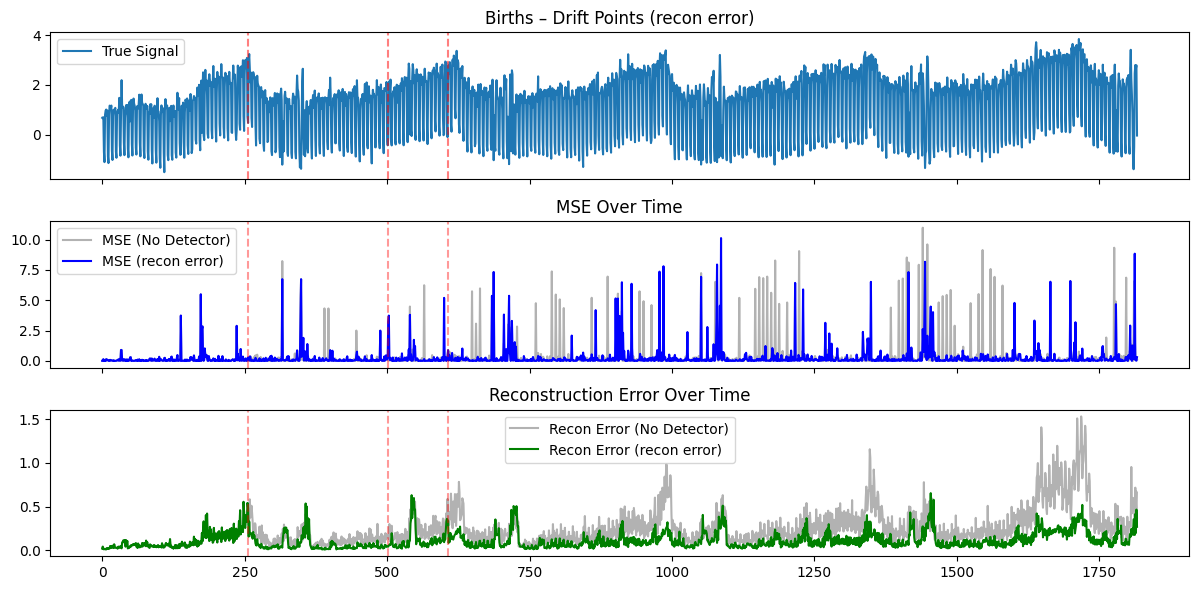

[Metric: cosine] Detector: mean       | MSE: 0.2960 | Time: 52.35s | Drifts: 3


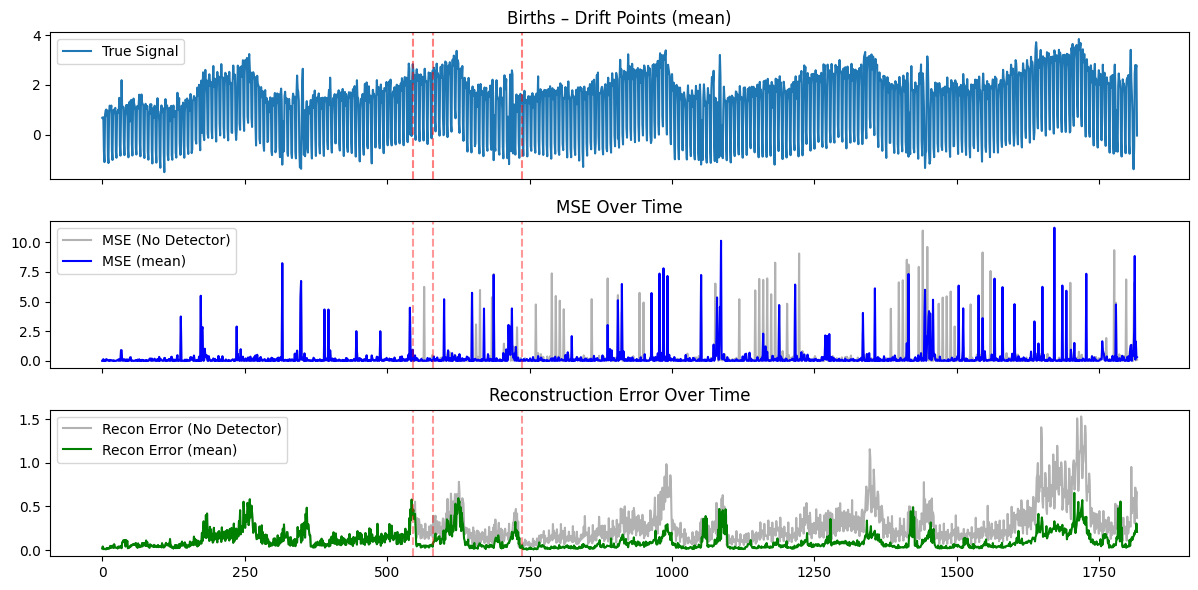


=== Dataset: OfficeTemp ==
> Detectors and parameters:
  None: None (no drift detection)
  recon error: mu0=0.0967, r=4.955996, sigma=0.026
  mean: mu0=0.3726, r=6.319280, sigma=0.01
[Metric: cosine] Detector: None       | MSE: 0.1407 | Time: 50.40s | Drifts: 0


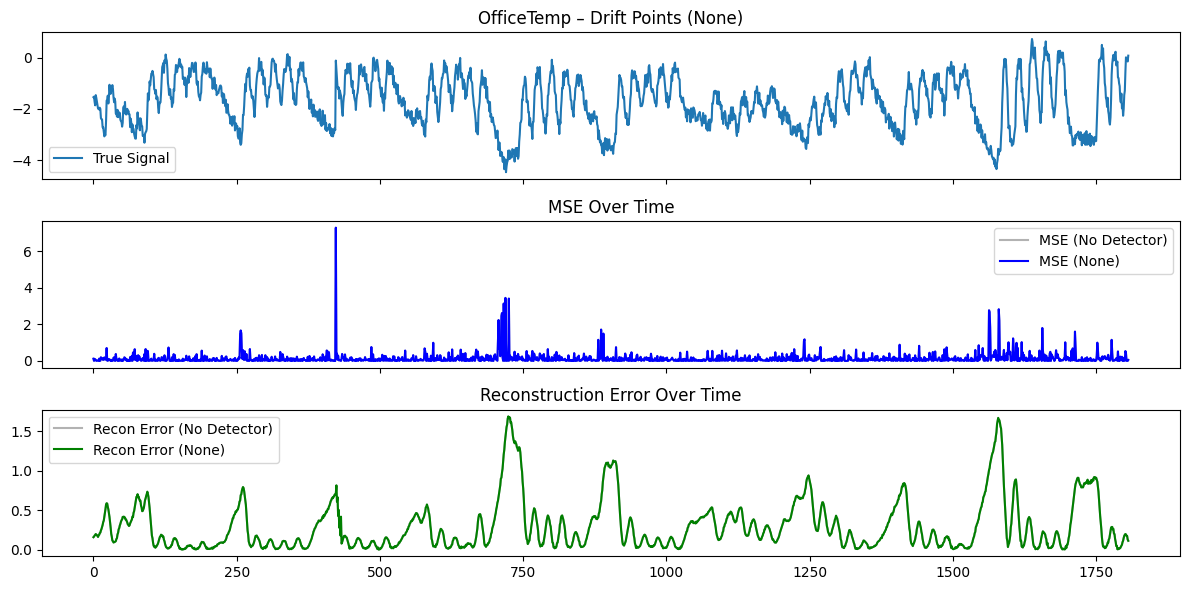

[Metric: cosine] Detector: recon error | MSE: 0.1463 | Time: 55.86s | Drifts: 1


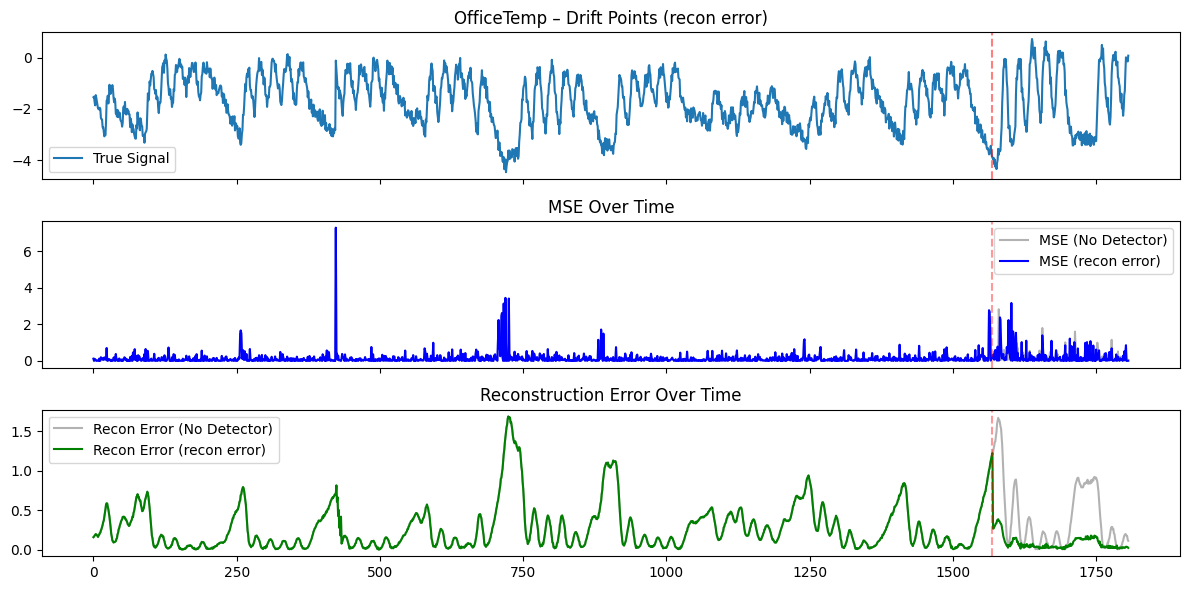

[Metric: cosine] Detector: mean       | MSE: 0.1354 | Time: 48.72s | Drifts: 3


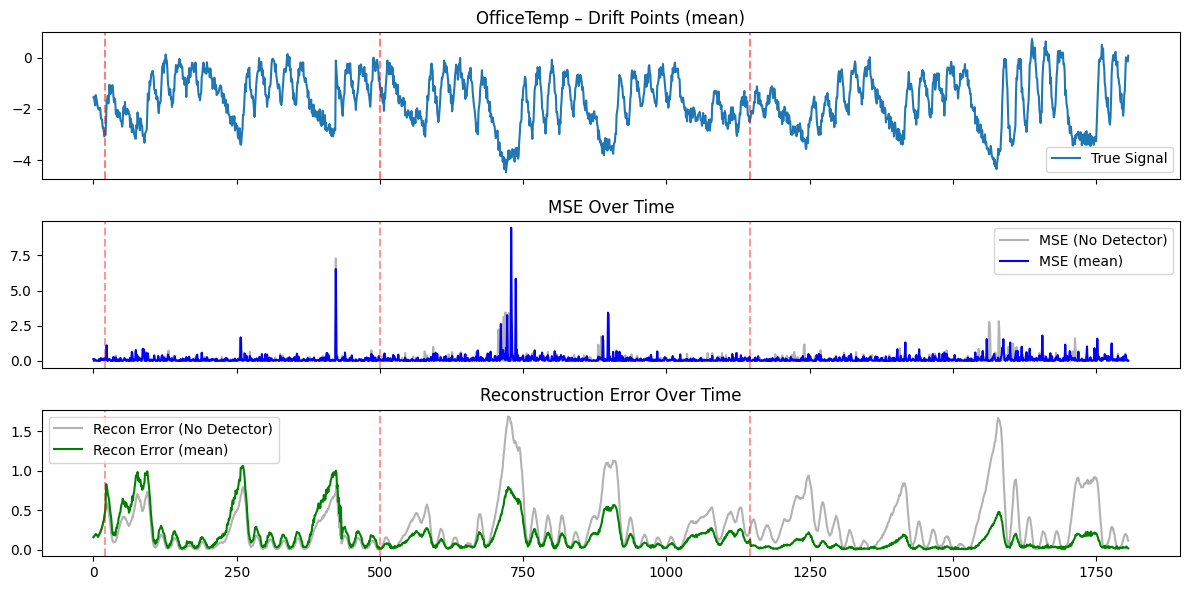


=== Dataset: SolarPower ==
> Detectors and parameters:
  None: None (no drift detection)
  recon error: mu0=0.0392, r=0.193909, sigma=0.026
  mean: mu0=-0.0766, r=2.452344, sigma=0.01
[Metric: cosine] Detector: None       | MSE: 0.2365 | Time: 18.17s | Drifts: 0


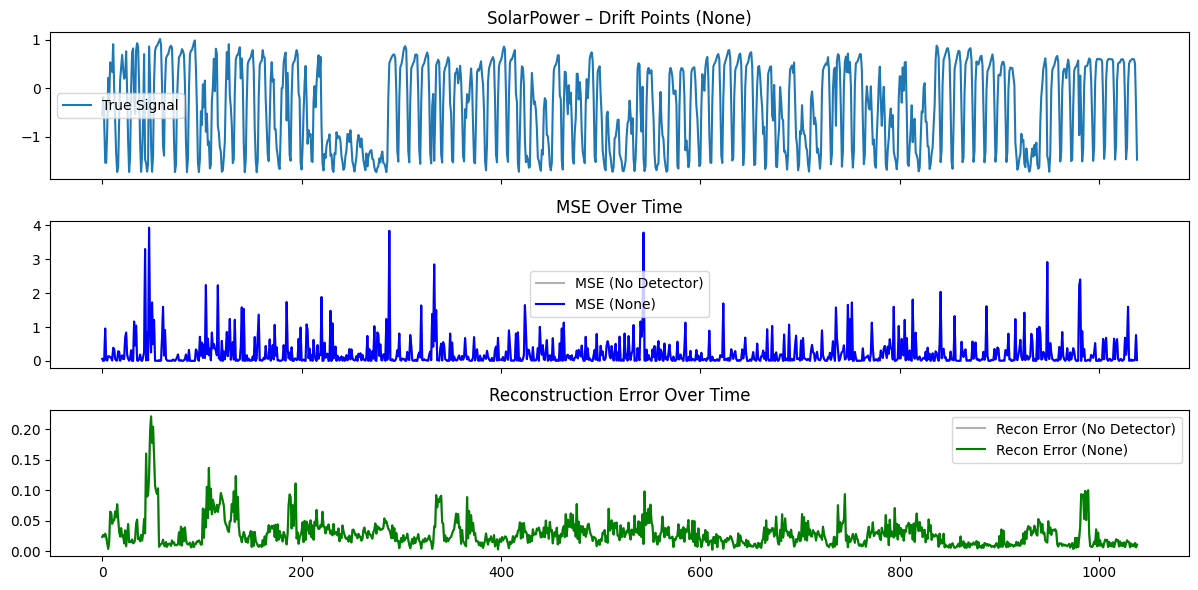

[Metric: cosine] Detector: recon error | MSE: 0.2319 | Time: 22.17s | Drifts: 1


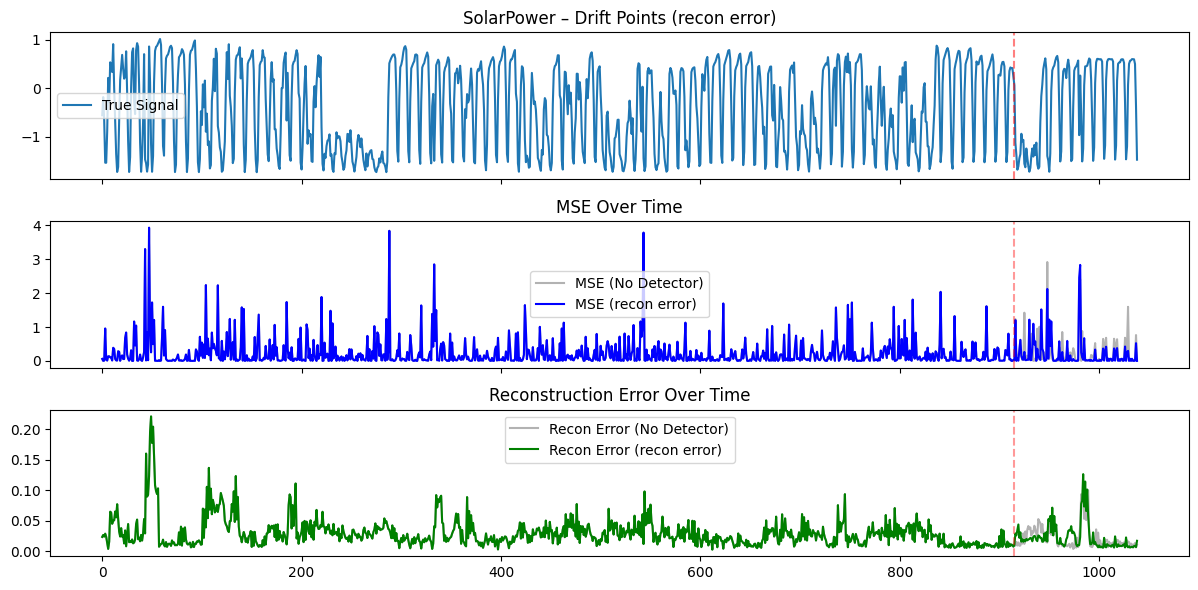

[Metric: cosine] Detector: mean       | MSE: 0.2151 | Time: 37.01s | Drifts: 5


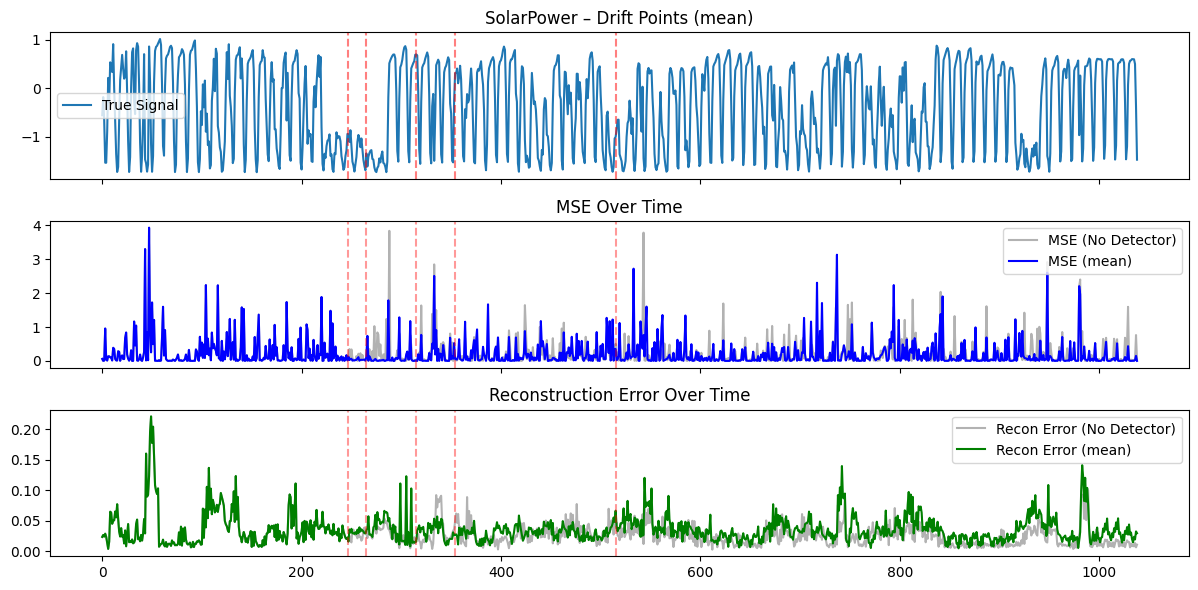

In [21]:
import copy

# Configurable parameters
recent_n_windows_ratio = 0.25  # adaptation set size
percentage = 0.75              # split training/validation
append = False                 # False to discard old RoC
metric = "cosine"           # best metric from the experiment

print(
    f"> Bottleneck size: {latent_dim}, "
    f"Adaptation set size: {recent_n_windows_ratio}, "
    f"Append to old RoC: {append}, "
    f"Split train/val: {percentage * 100:.1f}%"
)

baseline_mse_per_step = {}
baseline_recon_per_step = {}

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ==")

    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    n_windows = len(X_test)

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    refs = loaded[ds_name]["detector_refs"]  # mu_ref_* and R_* computed earlier

    # --- dataset-specific detector builder ---
    detector_factories = {
        "None": None,
        "recon error": lambda: FixedRefHoeffdingDetector(
            mu_ref=refs["mu_ref_recon"], r=refs["R_RECON"], sigma=0.026
        ),
        "mean": lambda: FixedRefHoeffdingDetector(
            mu_ref=refs["mu_ref_mean"], r=refs["R_MEAN"], sigma=0.01
        ),
    }

    print("> Detectors and parameters:")
    for name, factory in detector_factories.items():
        if factory is None:
            print(f"  {name}: None (no drift detection)")
        else:
            d = factory()
            print(f"  {name}: mu0={d.mu0:.4f}, r={d.r:.6f}, sigma={d.sigma}")

    # --- main eval loop per detector ---
    for detector_name, factory in detector_factories.items():
        print(f"[Metric: {metric}] Detector: {detector_name:<10}", end=" | ")

        current_ae = ae
        current_forecasters = {name: copy.deepcopy(model) for name, model in forecasters.items()}
        detector = None if factory is None else factory()

        preds, y_trues, reconstruction_errors, mse_per_step = [], [], [], []

        t0 = time.perf_counter()
        for i, (window, y_true) in enumerate(zip(X_test, y_test)):
            with torch.no_grad():
                inp = torch.tensor(window, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
                latent = current_ae.encode(window).cpu()
                recon = current_ae(inp).cpu().squeeze().numpy()
            recon_error = mean_squared_error(window, recon)
            reconstruction_errors.append(recon_error)

            # model selection
            best_name, best_dist = None, float("inf")
            for name, model in current_forecasters.items():
                for entry in model.rocs["latent"]:
                    d = compute_distance(latent, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name

            y_pred = current_forecasters[best_name].predict(window)
            preds.append(y_pred)
            y_trues.append(y_true)
            mse_per_step.append((y_pred - y_true) ** 2)

            # detector update
            if detector is not None:
                if detector_name == "recon error":
                    drift_signal = recon_error  # scalar from reconstruction error
                elif detector_name == "mean":
                    drift_signal = np.mean(window)  # scalar mean of raw values

                if detector.update(drift_signal, i):
                    full_n_windows = len(X_train) + len(X_val) + len(X_test)
                    recent_n_windows = int(recent_n_windows_ratio * full_n_windows)
                    all_X = np.vstack([X_train, X_val, X_test])
                    all_y = np.concatenate([y_train, y_val, y_test])
                    test_offset = len(X_train) + len(X_val)
                    end_idx = test_offset + i
                    start_idx = max(0, end_idx - recent_n_windows)
                    X_recent = all_X[start_idx:end_idx]
                    y_recent = all_y[start_idx:end_idx]
                    cutoff = int(len(X_recent) * percentage)
                    current_ae = retrain_autoencoder(X_recent[:cutoff], ds_name)
                    rebuild_rocs(
                        current_ae,
                        current_forecasters,
                        X_recent[cutoff:],
                        y_recent[int(len(y_recent) * percentage):],
                        append=append
                    )

        elapsed = time.perf_counter() - t0
        mse = mean_squared_error(y_trues, preds)
        drift_count = 0 if detector is None else len(detector.get_drift_points())
        print(f"MSE: {mse:.4f} | Time: {elapsed:.2f}s | Drifts: {drift_count}")

        if detector_name == "None":
            baseline_mse_per_step[ds_name] = mse_per_step
            baseline_recon_per_step[ds_name] = reconstruction_errors

        drift_points = detector.get_drift_points() if detector is not None else []

        fig, axs = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

        # Plot 1: True signal
        axs[0].plot(range(n_windows), y_test, label="True Signal")
        for idx in drift_points:
            axs[0].axvline(idx, color="red", linestyle="--", alpha=0.5)
        axs[0].set_title(f"{ds_name} – Drift Points ({detector_name})")
        axs[0].legend()

        # Plot 2: MSE over time
        axs[1].plot(baseline_mse_per_step.get(ds_name, []), label="MSE (No Detector)", color="gray", alpha=0.6)
        axs[1].plot(mse_per_step, label=f"MSE ({detector_name})", color="blue")
        for idx in drift_points:
            axs[1].axvline(idx, color="red", linestyle="--", alpha=0.4)
        axs[1].set_title("MSE Over Time")
        axs[1].legend()

        # Plot 3: Recon error over time
        axs[2].plot(baseline_recon_per_step.get(ds_name, []), label="Recon Error (No Detector)", color="gray", alpha=0.6)
        axs[2].plot(reconstruction_errors, label=f"Recon Error ({detector_name})", color="green")
        for idx in drift_points:
            axs[2].axvline(idx, color="red", linestyle="--", alpha=0.4)
        axs[2].set_title("Reconstruction Error Over Time")
        axs[2].legend()

        plt.tight_layout()
        plt.show()


In [11]:
# import copy
# import itertools
# import pandas as pd

# # === Fixed Hoeffding parameters ===
# fixed_sigma = 0.01

# metric = "cosine"
# top_k = 5  # Show top-K configs per dataset

# # Grid search parameters (only adaptation-related)
# ratios = [0.5, 0.25, 0.10]
# percentages = [0.75, 0.5, 0.25]
# append_options = [False, True]
# param_grid = list(itertools.product(ratios, percentages, append_options))

# results = []

# for ds_name, DS, length, window_size in ts_configs:
#     print(f"\n=== Grid Search for Dataset: {ds_name} ===")
#     ts = DS(length=length)
#     X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
#     base_ae = loaded[ds_name]["ae"]
#     base_forecasters = loaded[ds_name]["forecasters"]
#     refs = loaded[ds_name]["detector_refs"]  # mu_ref_recon / R_RECON computed earlier

#     # === Detector setup (dataset-specific) ===
#     detector_classes = {
#         "recon error": lambda: FixedRefHoeffdingDetector(
#             mu_ref=refs["mu_ref_recon"], r=refs["R_RECON"], sigma=fixed_sigma
#         ),
#     }

#     for recent_n_windows_ratio, percentage, append in param_grid:
#         for detector_name, DetectorClass in detector_classes.items():
#             current_ae = base_ae
#             current_forecasters = {name: copy.deepcopy(m) for name, m in base_forecasters.items()}
#             detector = DetectorClass()

#             preds, y_trues = [], []

#             for i, (window, y_true) in enumerate(zip(X_test, y_test)):
#                 with torch.no_grad():
#                     inp = torch.tensor(window, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
#                     latent = current_ae.encode(window).cpu()
#                     recon = current_ae(inp).cpu().squeeze().detach().numpy()

#                 # Mean reconstruction error for the window (scalar input to detector)
#                 recon_error = mean_squared_error(window, recon)

#                 best_name, best_dist = None, float("inf")
#                 for name, model in current_forecasters.items():
#                     for entry in model.rocs["latent"]:
#                         d = compute_distance(latent, entry, metric=metric)
#                         if d < best_dist:
#                             best_dist = d
#                             best_name = name

#                 y_pred = current_forecasters[best_name].predict(window)
#                 preds.append(y_pred)
#                 y_trues.append(y_true)

#                 if detector.update(recon_error, i):
#                     full_n_windows = len(X_train) + len(X_val) + len(X_test)
#                     recent_n_windows = int(recent_n_windows_ratio * full_n_windows)
#                     all_X = np.vstack([X_train, X_val, X_test])
#                     all_y = np.concatenate([y_train, y_val, y_test])
#                     test_offset = len(X_train) + len(X_val)
#                     end_idx = test_offset + i
#                     start_idx = max(0, end_idx - recent_n_windows)
#                     X_recent = all_X[start_idx:end_idx]
#                     y_recent = all_y[start_idx:end_idx]
#                     cutoff = int(len(X_recent) * percentage)
#                     current_ae = retrain_autoencoder(X_recent[:cutoff], ds_name)
#                     rebuild_rocs(
#                         current_ae,
#                         current_forecasters,
#                         X_recent[cutoff:], 
#                         y_recent[int(len(y_recent) * percentage):],
#                         append=append
#                     )

#             mse = mean_squared_error(y_trues, preds)
#             drift_count = len(detector.get_drift_points())
#             results.append({
#                 "dataset": ds_name,
#                 "recent_ratio": recent_n_windows_ratio,
#                 "percentage": percentage,
#                 "append": append,
#                 "sigma": fixed_sigma,   # replaced delta with sigma
#                 "mse": mse,
#                 "drifts": drift_count,
#             })

#     # After all configs for current dataset: show Top-K
#     df_subset = pd.DataFrame([r for r in results if r["dataset"] == ds_name])
#     top_k_df = df_subset.sort_values("mse").head(top_k)
#     print(f"\nTop {top_k} configs for {ds_name}:")
#     print(top_k_df[["recent_ratio", "percentage", "append", "sigma", "mse", "drifts"]]
#           .to_string(index=False, float_format="%.4f"))

# # Save full results
# df_grid = pd.DataFrame(results)
# df_grid.to_csv("results/adaptation_config_search.csv", index=False)

# # Average MSE per config
# summary = (
#     df_grid
#     .groupby(["recent_ratio", "percentage", "append", "sigma"])
#     .agg(avg_mse=("mse", "mean"))
#     .reset_index()
#     .sort_values("avg_mse")
# )

# print("\n=== Average MSE per Adaptation Config (across all datasets) ===")
# print(summary.to_string(index=False, float_format="%.4f"))
